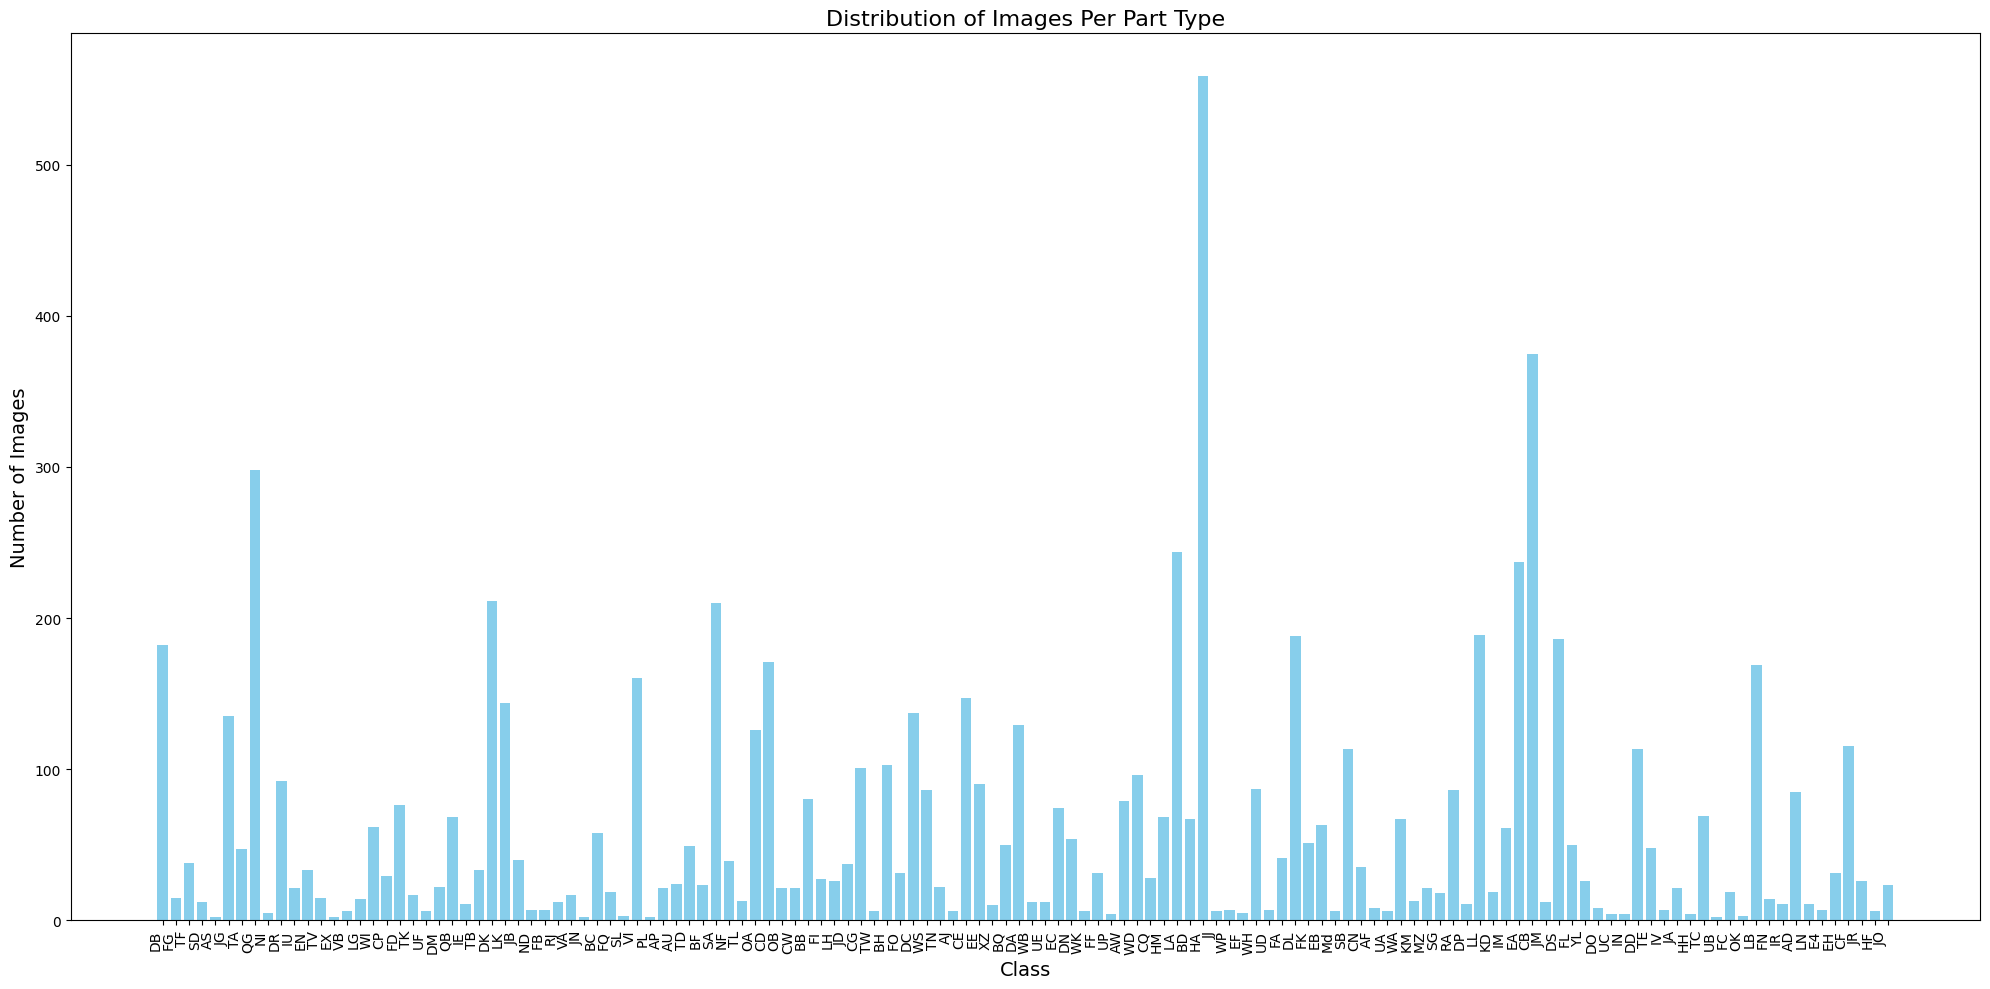

In [5]:
import pandas as pd
import os
import matplotlib.pyplot as plt

# Path to the folder containing class folders
data_path = "data_api"

# Dictionary to store the number of images per class
class_image_count = {}

# Traverse through the classes and count images
for class_folder in os.listdir(data_path):
    class_path = os.path.join(data_path, class_folder)
    if os.path.isdir(class_path):
        num_images = len([file for file in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, file))])
        class_image_count[class_folder] = num_images

# Plot the distribution
classes = list(class_image_count.keys())
image_counts = list(class_image_count.values())

plt.figure(figsize=(20, 10))
plt.bar(classes, image_counts, color='skyblue')
plt.xlabel("Class", fontsize=14)
plt.ylabel("Number of Images", fontsize=14)
plt.title("Distribution of Images Per Part Type", fontsize=16)
plt.xticks(rotation=90, ha='right', fontsize=10)
plt.tight_layout()
plt.show()

In [8]:
list(class_image_count.values())
sum(class_image_count.values())

7857

In [9]:
len(class_image_count.keys())

132